<a href="https://colab.research.google.com/github/shreyashrawat/RCNN_from_scratch/blob/master/BasicRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/datitran/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 652, done.
remote: Total 652 (delta 0), reused 0 (delta 0), pack-reused 652
Receiving objects: 100% (652/652), 48.01 MiB | 37.10 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [2]:
def compute_iou(boxA, boxB):
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])

  overlap = (xB-xA+1) * (yB-yA+1)

  boxAarea = (boxA[2]-boxA[0]+1) * (boxA[3]-boxA[1]+1)
  boxBarea = (boxB[2]-boxB[0]+1) * (boxB[3]-boxB[1]+1)

  iou = overlap/float(boxAarea + boxBarea - overlap)

  return iou

In [3]:
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [4]:
maxPos = 30
maxNeg = 10
maxProposals = 2000
maxInfer = 200

In [5]:
images_dir = "/content/raccoon_dataset/images/"
annot_dir = "/content/raccoon_dataset/annotations/"

In [6]:
!mkdir classification_dataset

In [7]:
!mkdir classification_dataset/positive
!mkdir classification_dataset/negative

In [8]:
posPath = "/content/classification_dataset/positive/"
negPath = "/content/classification_dataset/negative/"

In [143]:
for (i,img_path) in enumerate(os.listdir(images_dir)):

  img_name = img_path.split(".")[0]
  annotPath = annot_dir+img_name+".xml"

  contents = open(annotPath).read()
  soup = BeautifulSoup(contents, "html.parser")
  gtBoxes = []

  w = int(soup.find("width").string)
  h = int(soup.find("height").string)

  for o in soup.find_all("object"):

    label = o.find("name").string
    xMin = int(o.find("xmin").string)
    xMax = int(o.find("xmax").string)
    yMin = int(o.find("ymin").string)
    yMax = int(o.find("ymax").string)

    xMin = max(0, xMin)
    yMin = max(0, yMin)
    xMax = max(w, xMax)
    yMax = max(h, yMax)

    gtBoxes.append((xMin, yMin, xMax, yMax))

  image = cv2.imread(images_dir+img_path)

  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()
  proposedRects = []
  positiveROI = 0
  negativeROI = 0

  for (x,y,w,h) in rects:

    proposedRects.append((x,y,x+w,y+h))
  
  for proposedRect in proposedRects[:2000]:

    propStartx, propStarty, propEndx, propEndy = proposedRect
    for gtBox in gtBoxes:
      iou = compute_iou(gtBox, proposedRect)
      (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox

      if iou>0.7 and positiveROI<30:
        roi = image[propStarty:propEndy,propStartx:propEndx]
        roi = cv2.resize(roi, (224,224))
        cv2.imwrite(posPath+str(i)+"-"+str(positiveROI)+".jpg", roi)
        positiveROI += 1

      fullOverlap = propStartx >= gtStartX
      fullOverlap = fullOverlap and propStarty >= gtStartY
      fullOverlap = fullOverlap and propEndx <= gtEndX
      fullOverlap = fullOverlap and propEndy <= gtEndY

      if not fullOverlap and iou<0.05 and negativeROI<10:
        roi = image[propStarty:propEndy, propStartx:propEndx]
        roi = cv2.resize(roi, (224,224))
        cv2.imwrite(negPath+str(i)+"-n-"+str(negativeROI)+".jpg", roi)
        negativeROI += 1

In [10]:
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications import MobileNetV2
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import keras

In [11]:
def load_data(dir):
  X = []
  y = []
  for img_path in os.listdir(dir+"positive"):
    img = load_img(dir+"positive/"+img_path, (224,224))
    img = img_to_array(img)
    X.append(preprocess_input(img))
    y.append(1)
  for img_path in os.listdir(dir+"negative"):
    img = load_img(dir+"negative/"+img_path, (224,224))
    img = img_to_array(img)
    X.append(preprocess_input(img))
    y.append(0)
  return np.stack(X), np.array(y)
  

In [12]:
X,y = load_data("/content/classification_dataset/")

In [13]:
len(X)

3671

In [14]:
base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (224,224,3))

9412608/9406464 [==============================] - 0s 0us/step


In [15]:
for layer in base_model.layers:
	layer.trainable = False

In [16]:
model = Sequential([
                    base_model,
                    keras.layers.AveragePooling2D((7,7)),
                    keras.layers.Flatten(),
                    keras.layers.Dense(128, "relu"),
                    keras.layers.Dropout(0.5),
                    keras.layers.Dense(1, "sigmoid")
])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [18]:
model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['acc'])

In [19]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_data=(X_test,y_test))

Epoch 1/5
92/92 [==============================] - 120s 1s/step - loss: 0.1419 - acc: 0.9571 - val_loss: 0.1075 - val_acc: 0.9728
Epoch 2/5
92/92 [==============================] - 119s 1s/step - loss: 0.0700 - acc: 0.9796 - val_loss: 0.0846 - val_acc: 0.9810
Epoch 3/5
92/92 [==============================] - 119s 1s/step - loss: 0.0562 - acc: 0.9830 - val_loss: 0.0847 - val_acc: 0.9796
Epoch 4/5
92/92 [==============================] - 119s 1s/step - loss: 0.0407 - acc: 0.9850 - val_loss: 0.0806 - val_acc: 0.9823
Epoch 5/5
92/92 [==============================] - 121s 1s/step - loss: 0.0342 - acc: 0.9860 - val_loss: 0.0877 - val_acc: 0.9810


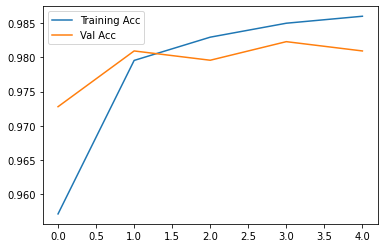

In [144]:
plt.plot(history.history["acc"], label = "Training Acc")
plt.plot(history.history["val_acc"], label = "Val Acc")
plt.legend()

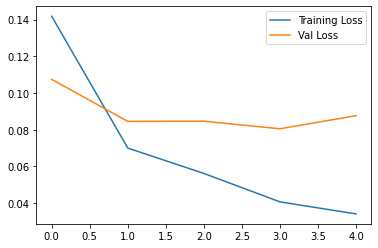

In [145]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.legend()

In [121]:
from imutils.object_detection import non_max_suppression
import imutils

# Running on test image

In [128]:
image = cv2.imread("/content/raccoon_dataset/images/raccoon-116.jpg")
image = imutils.resize(image, width = 500)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

In [129]:
proposals = []
boxes = []

In [130]:
for (x,y,w,h) in rects[:2000]:
  roi = image[y:y+h, x:x+w]
  roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
  roi = cv2.resize(roi, (224,224))
  # roi = img_to_array(roi)
  roi = preprocess_input(roi)
  proposals.append(roi)
  boxes.append((x,y,x+w,y+h))  

In [132]:
boxes = np.array(boxes, dtype = "int32")
proposals = np.array(proposals, dtype="float32")

In [133]:
proba = model.predict(proposals)

In [134]:
idxs = np.where(proba > 0.99)[0]

In [135]:
boxes_pos = np.array(boxes)[idxs]
proba = proba[idxs]

In [136]:
len(boxes_pos)

45

In [137]:
boxes = non_max_suppression(boxes_pos, proba)

/usr/local/lib/python3.6/dist-packages/imutils/object_detection.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return boxes[pick].astype("int")


In [138]:
len(boxes)

1

In [139]:
clone = image.copy()

In [140]:
for box in boxes:
  startX, startY, endX, endY = box
  cv2.rectangle(clone, (startX, startY), (endX,endY), (0,255,0), 2)


In [126]:
from google.colab.patches import cv2_imshow

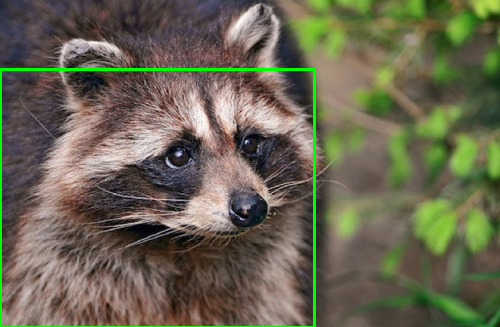

In [141]:
cv2_imshow(clone)